# Simulated logic for delivering stim A and stim B

In [1]:
import os, glob, re

import numpy as np
import pandas as pd

from scipy import signal
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

## Use existing data as inputs for simulations

### Sniff rate extraction 

In [2]:
# helper functions for calculating sniff rates
# these are only used offline, not to be used online/real-time

def butter_filter(data, Fs, order, low=None, high=None):
    """
    Filter `data` (sampled at `Fs` Hz) with Butterworth filter `order`
    - `low`: low cut [Hz], allowing only higher, i.e. highpass if not `None`
    - `high`: high cut [Hz], allowing only lower, i.e. lowpass if not `None`
    Assume bandpass [`low`, `high`] if both are not `None`
    """
    Fnq = Fs / 2
    has_low, has_high = low is not None, high is not None
    assert has_low or has_high, 'Need at least `low` or `high`' 
    if has_low and not has_high:
        args = [low/Fnq, 'highpass']
    elif has_high and not has_low:
        args = [high/Fnq, 'lowpass']
    else: 
        assert low < high
        args = [[low/Fnq, high/Fnq], 'bandpass']
    b, a = signal.butter(order, *args)
    data = signal.filtfilt(b, a, data)
    return data


def construct_gausswin(Fs, size_sec=1, std_factor=0.1):
    """
    Construct Gaussian window for signal sampled at `Fs` Hz
    of size `size_sec` [default: `1`] seconds (to get # points) 
    and stdev scaled by `std_factor` [default: `0.1`] from # points
    """
    num_points = round(Fs * size_sec)
    win_std = std_factor * num_points
    win = signal.windows.gaussian(num_points, win_std)
    win /= win.sum()
    return win

def compute_sniff(flow, dt, filter_kwargs=dict(), peak_kwargs=dict(), gauss_kwargs=dict(), verbose=True):
    """
    Compute sniff rate from `nwb` object per trial
    - `filter_kwargs`: filter option dict 
        - default: `dict(order=2, low=2, high=30)`
        - see `butter_filter` function for description of `oder`, `low`, `high`
    - `peak_kwargs`: peak detection option dict (after z-score)
        - default: `dict(use_negative=True, prominence=1, distance_sec=0.04)`
        - `use_negative`: invert signal to find peaks
        - `prominence`: peak prominence after z-score normalization 
        - `distance_sec`: peak distance in seconds
    - `gauss_kwargs`: gaussian window construction option dict for smoothing
        - default: `dict(size_sec=2, std_factor=0.1)`
        - see `construct_gausswin` for description on `size_sec` and `std_factor`
    Returns: a dict of list of trials of `sniff_rate` (Hz) and `t` time vec    
    """
    # get raw sniff data
    t = np.arange(len(flow)) * dt
    sniff = flow
    Fs = 1 / dt
    
    # default kwargs 
    def_filter_kwargs = dict(order=2, low=2, high=30)
    def_peak_kwargs = dict(use_negative=True, prominence=1, distance_sec=0.04)
    def_gauss_kwargs = dict(size_sec=2, std_factor=0.1)
    
    # update kwargs
    filter_kwargs = def_filter_kwargs.copy(); filter_kwargs.update(**filter_kwargs)
    peak_kwargs   = def_peak_kwargs.copy(); peak_kwargs.update(**peak_kwargs)
    gauss_kwargs  = def_gauss_kwargs.copy(); gauss_kwargs.update(**gauss_kwargs)
    
    # some processing of kwargs 
    peak_kwargs['distance'] = Fs * peak_kwargs['distance_sec']
    use_negative_peaks = peak_kwargs.get('use_negative', True)
    del peak_kwargs['distance_sec'], peak_kwargs['use_negative']
    assert gauss_kwargs['size_sec'] * Fs < len(t), 'gauss win size too big'

    # z-scale -> filter -> peak
    sniff = StandardScaler().fit_transform(sniff[:,None]).flatten() 
    sniff = butter_filter(sniff, Fs=Fs, **filter_kwargs)
    if use_negative_peaks: sniff = -sniff
    pk_loc, _ = signal.find_peaks(sniff, **peak_kwargs)
    
    # events -> rate
    events = np.zeros(len(t))
    events[pk_loc] = 1 / dt # so each peak has unit in second
    win = construct_gausswin(Fs, **gauss_kwargs)
    rate = np.convolve(events, win, mode='same')
    
    return t, rate

In [3]:
# comment this out to download sample data
# !mkdir -p data
# !wget -P data https://gin.g-node.org/fleischmann-lab/calimag-testdata/raw/orig/data/v2022_05-2p-Max/20220531_ME02.txt 

In [4]:
!head data/20220603_ME02.txt

\puffing\puffing.ino
Jun  3 2022
15:26:59
Done with setup. Type a>1 and press enter to start.
a1>
55162,2,189,927,0,0
1,7,192,927,0,1
2,7,214,927,0,1
3,7,217,927,0,1
4,7,230,3849,0,1


In [5]:
# these are flow recordings from previous experiments
# we'll use these as simulated inputs
# file = 'data/20220603_ME02.txt'
# file = 'data/20220607_ME02.txt'
file = 'data/20220531_ME02.txt'
udf = (
    pd.read_csv(
        file,
        names=['time', 'odor', 'flow', 'wheel', 'odor_on', 'trial'],
        on_bad_lines='skip',
    )
    .dropna(how='any')
    .astype('int')
    .reset_index(drop=True)
)
udf

<ipython-input-5-7402fe4636d1>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


time  odor  flow  wheel  odor_on  trial
0        57401     2   138    938        0      0
1            1     5   134    938        0      1
2            2     5   137    532        0      1
3            3     5   141    532        0      1
4            4     5   124    532        0      1
...        ...   ...   ...    ...      ...    ...
2250085  24996     4   231   2725        0     90
2250086  24997     4   222   2725        0     90
2250087  24998     4   216   2118        0     90
2250088  24999     4   218   2118        0     90
2250089  25000     4   211   2118        0     90

[2250090 rows x 6 columns]

In [6]:
# compute sniff rate
# assume that this is computed in real-time somehow
# will use to come up with "candidates" for inputs

flow_dt_sec = 1e-3
flow = udf['flow'].to_numpy()

t, sniff_rate = compute_sniff(
    flow, 
    dt = flow_dt_sec,
    peak_kwargs = dict(
        prominence=0.75, 
        distance_sec=0.01
    ),
    gauss_kwargs = dict(
        size_sec=1,
        std_factor=0.1
    )
)

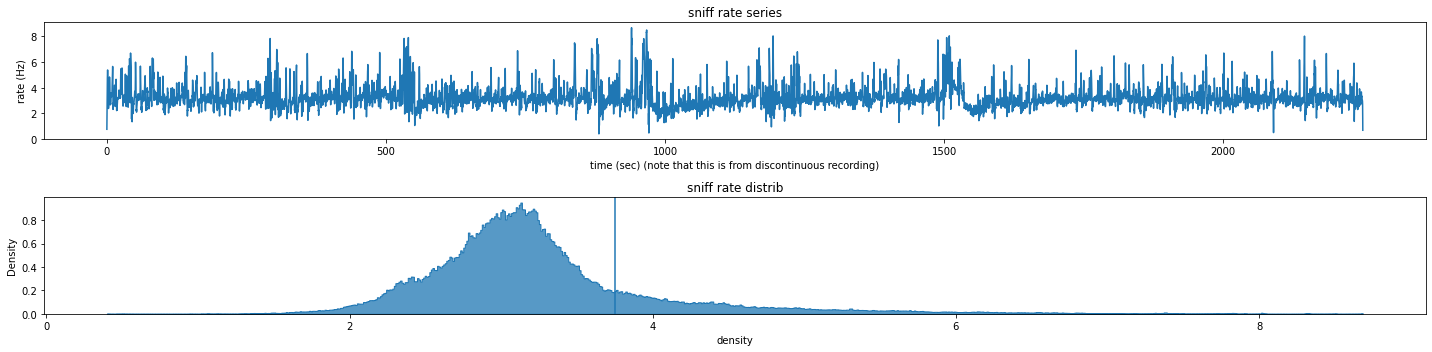

In [7]:
# adjust this threshold based on the distrib plot
min_rate = 3.75

plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(t, sniff_rate)

plt.xlabel('time (sec) (note that this is from discontinuous recording)')
plt.ylabel('rate (Hz)')
plt.title('sniff rate series')

plt.subplot(212)
sns.histplot(sniff_rate, element='step', stat='density')
plt.axvline(min_rate)
plt.xlabel('rate (Hz)')
plt.xlabel('density')
plt.title('sniff rate distrib')
plt.tight_layout()


### Peak of sniff rates as stim A candidates

In [8]:
# more restrictive version of rate peaks
rate_peak_loc, _ = signal.find_peaks(
    sniff_rate,
    distance=5/flow_dt_sec, # 5 sec apart
    height=min_rate,
    prominence=1
)

# more "free" version of rate peak detection
# i.e. only crossing thresholds, no other criteria
# this will be used as candidates to simulate stimulus
# e.g. from another teensy
free_rate_peak_loc, _ = signal.find_peaks(
    sniff_rate,
    height=min_rate,
)


Text(0.5, 0, 'time (sec)')

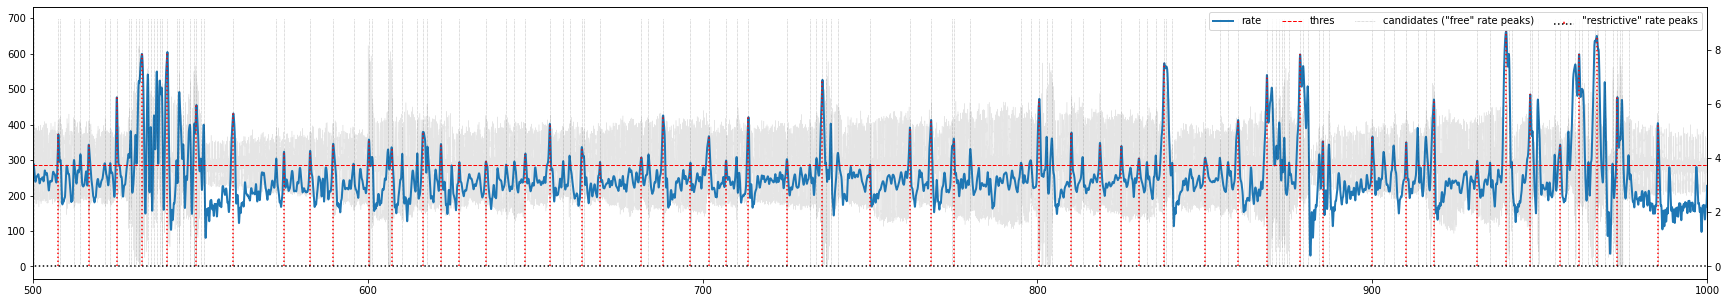

In [9]:
plt.figure(figsize=(30,5))
plt.plot(t, flow, '-k', lw=0.5, alpha=0.1, label='flow')

ax_twinx = plt.gca().twinx()
ax_twinx.plot(t, sniff_rate, lw=2, label='rate')
ax_twinx.axhline(y=min_rate, ls='--', c='r', lw=1, label='thres')
ax_twinx.vlines(
    x=t[free_rate_peak_loc],
    ymin=0, ymax=max(sniff_rate)*1.05, 
    ls=':', lw=0.5, colors='k', alpha=0.5,
    label='candidates ("free" rate peaks)',
)
ax_twinx.stem(
    t[rate_peak_loc], sniff_rate[rate_peak_loc],
    linefmt = ':r',
    basefmt=':k',
    markerfmt= 'none',
    label='"restrictive" rate peaks'
)

plt.legend(ncols=4)
plt.xlim([500,1000])
plt.xlabel('time (sec)')

### ISI distrib

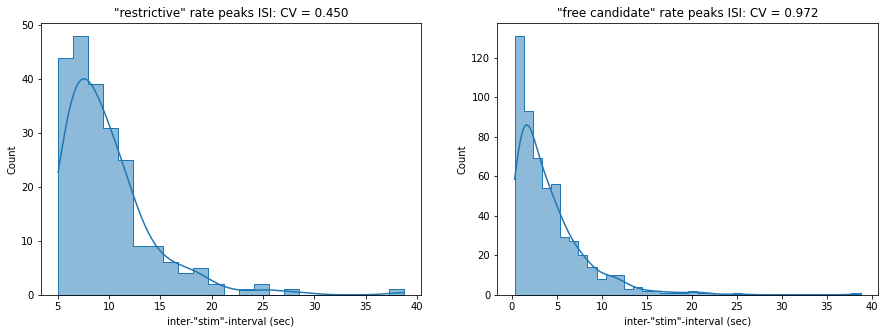

In [10]:
high_free_rate_isi = np.diff(t[free_rate_peak_loc])
high_rate_isi = np.diff(t[rate_peak_loc])

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.histplot(high_rate_isi, element='step', kde=True)
plt.title(f'"restrictive" rate peaks ISI: CV = {high_rate_isi.std() / high_rate_isi.mean():0.3f}')
plt.xlabel('inter-"stim"-interval (sec)')

plt.subplot(122)
sns.histplot(high_free_rate_isi, element='step', kde=True)
plt.title(f'"free candidate" rate peaks ISI: CV = {high_free_rate_isi.std() / high_free_rate_isi.mean():0.3f}')
plt.xlabel('inter-"stim"-interval (sec)')


plt.show()

What's this is telling is basically the "free" candidate ISI is very close to that of a Poisson process, which is the basis of the logic of emulation below. Unclear if different distributions of "free" candidates can use the same logic ...

In [11]:
1 / high_free_rate_isi.mean(),1 / high_rate_isi.mean()

(0.24120343124141738, 0.10143070919726307)

## Simulate experiment

### Parameters

In [12]:
## general time parameters
# total simulated experiment time [ms]
# e.g. "3600e3" for 1 hr or use the last time point above
# note: will be set in teensy
T = t[-1] * 1e3

# teensy/arduino assumed time resolution [ms]
# note: will be set in teensy
dt = 1

## stim control parameters
# max consecutive similar event/stim outputs
# note: will be set in teensy
max_consec = 3

# initial estimate for stim B rate [1/ms]
# should keep lower than `1 / high_free_rate_isi.mean()`
# note: will be set in teensy
# rB_0 = 0.25e-3 
rB_0 = 0.05e-3
# rB_0 = 0.50e-3

# refractory time between any stim [ms]
# keep around 10-second to avoid overwhelm?
# note: will be set in teensy
t_ref = 10e3

# period to update control rate for B [ms]
# i.e. to "follow" rate for A
# note: will be set in teensy
t_rate_est_period = 1.5 * 60e3

## scope parameters
# delay between microcontroller onset and scope onset [ms]
# note: mostly for sim purposes, unclear if set in teensy or scope
t_delay = 10e3

# time of recording for each trial in scope [ms]
# note: mostly for sim purposes, unclear if set in teensy or scope
t_trial = 25e3

# inter-trial-interval for scope [ms]
t_ITI = 15e3

### Input

In [13]:
# emulate what's sending from the 2nd teensy to main teensy
# i.e. candidate A stimuli
num_steps = int(T/dt)
pre_A_vec = np.full(num_steps, False)
pre_A_vec[free_rate_peak_loc] = True

### Simulate

In [14]:
# state vectors
time_vec = [] # store time
scope_on_vec = [] # store if scope is on
At_vec = [] # store "actual" stim A time
Bt_vec = [] # store "actual" stim B time
rB_vec = [] # store rate of stim B
trial_vec = [] # store trial ID

# scope vars to keep track
scope_is_on = False # whether scope is one
scope_on_t = -1 # previous time that scope is on

# stim vars to keep track
prev_stim_t = -1 # previous time that stim is delivered
prev_stim_id = None # probably not needed

# stim counter vars to keep track
count_A = 0 # cumulative count of actual stim A
count_B = 0 # cumulative count of actual stim B

count_pA = 0 # cumulative count of pre_A (i.e. no refractory)
count_pB = 0 # cumulative count of pre_B (i.e. no refractory)

limit_count_A = 0 # counts used to limit A
limit_count_B = 0 # counts used to limit B

# initialize control rate of B
rB = rB_0
rB_control = rB_0

# trial counter
trial_cnt = 0

# simulate what teensy may be doing
# BIG NOTE: main logic
for i in tqdm(range(num_steps)):
    ti = i * dt # emulate timer
    time_vec.append(ti)
    
    # emulate getting A inputs
    # (e.g. sniff rate crossing some thres)
    pre_Ai = pre_A_vec[i] > 0
    count_pA += int(pre_Ai)
    
    # poisson-like prob
    # BIG NOTE: the random number generator needs to work properly!
    pre_Bi = rB * dt > np.random.rand()
    count_pB += int(pre_Bi)

    # emulate scope on/off
    if ti < t_delay:
        scope_on_vec.append(False)
        trial_vec.append(-1)
    else:
        if (
            scope_on_t < 0 or
            (ti - scope_on_t) < t_trial
        ):
            # turn on scope
            if not scope_is_on:
                # record onset of scope
                scope_is_on = True
                scope_on_t = ti
                trial_cnt += 1
                
            scope_on_vec.append(True)
            trial_vec.append(trial_cnt)
        else:
            scope_is_on = False
            scope_on_vec.append(False)
            trial_vec.append(-1)            
            if (ti - scope_on_t) >= t_trial + t_ITI:
                scope_on_t = -1
                
    # estimate rates on a period
    # important for defining how to output B
    # basically B rate is "chasing" after A rate
    if ti % t_rate_est_period == 0 and ti > 0:
        est_rA = count_pA / ti
        est_rB = count_pB / ti
        
        # try to make B more like A
        # rB_control = max(rB_0, est_rA)
        rB_control = est_rA
        
        # other versions could be
        # rB_control = est_rA
        # rB_control = max(rB_0, est_rA)
        # rB_control = (est_rA + est_rB) / 2 
        # rB_control = control_factor * est_rA + (1 - control_factor) * est_rB
        # rB_control = max(rB_0, (est_rA + est_rB) / 2)
        # rB_control = min(rB_0, (est_rA + est_rB) / 2)
                
    # decide on stimulus
    if (
        pre_Ai and 
        limit_count_A < max_consec and 
        ti - prev_stim_t > t_ref
    ):
        # emulate stim A out
        # and save stim time
        At_vec.append(ti)
        prev_stim_t = ti
        count_A += 1
        
        # these counts are used
        # to limit consec A stim
        # - increase count for A
        # - reset count for B
        limit_count_A += 1
        limit_count_B = 0

    if (
        pre_Bi and
        limit_count_B < max_consec and 
        ti - prev_stim_t > t_ref
    ):
        # emulate stim B out
        # and save stim time
        Bt_vec.append(ti)
        prev_stim_t = ti
        count_B += 1
        
        # the "original?" way to control
        # not spiking in refractory period
        # not sure if needed anymore?
        rB = 0
        
        # these counts are used
        # to limit consec B stim
        # - increase count for B
        # - reset count for A
        limit_count_B += 1
        limit_count_A = 0

    else:
        # update rate with refractory period
        drB = dt * (rB_control - rB) / t_ref
        rB = rB + drB
    
    rB_vec.append(rB_control)


  0%|          | 0/2250089 [00:00<?, ?it/s]

In [15]:
# convert to arrays and time [ms->sec]
time_vec = np.array(time_vec) * 1e-3
scope_on_vec = np.array(scope_on_vec)
At_vec = np.array(At_vec) * 1e-3
Bt_vec = np.array(Bt_vec) * 1e-3
rB_vec = np.array(rB_vec) * 1e3

### Visualize

<ipython-input-16-558a64fe7f59>:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


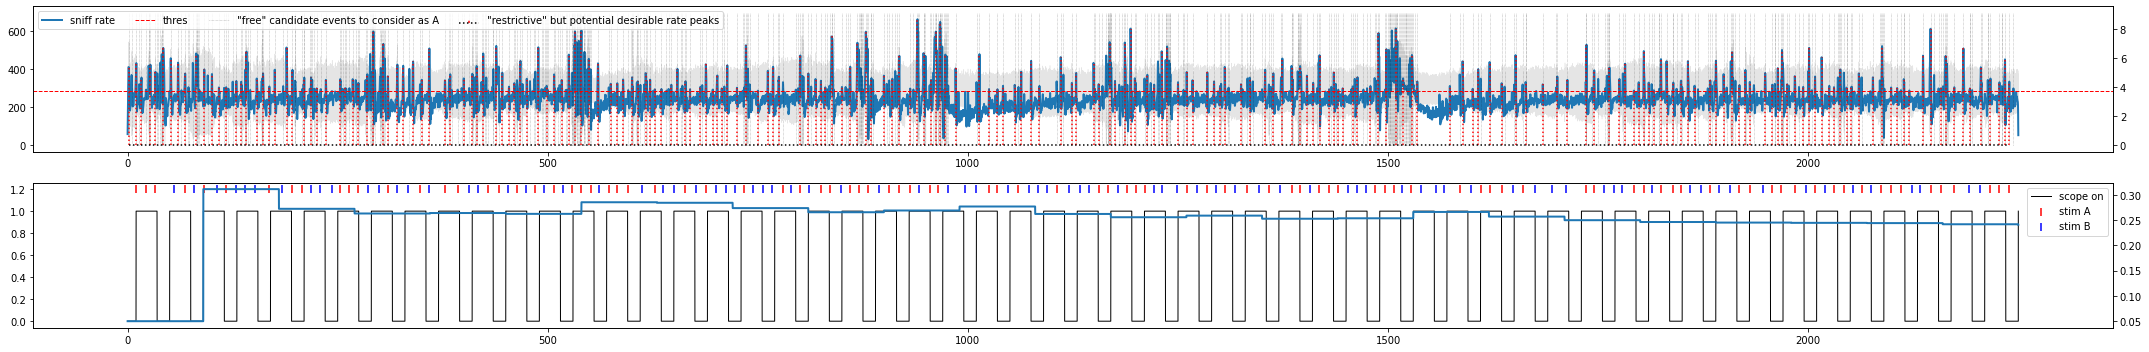

In [16]:
plt.figure(figsize=(30,5))

max_sniff_rate = max(sniff_rate)

plt.subplot(211)
plt.plot(t, flow, '-k', lw=0.5, alpha=0.1, label='flow')

ax_twinx = plt.gca().twinx()

# from experiment -> emulate sniff detection -> stim
ax_twinx.plot(t, sniff_rate, lw=2, label='sniff rate')

# min rate to consider stim A
ax_twinx.axhline(y=min_rate, ls='--', c='r', lw=1, label='thres')

# all peak rates passing min rate to consider stim A deliver
ax_twinx.vlines(
    x=t[free_rate_peak_loc],
    ymin=0, ymax=max(sniff_rate)*1.05, 
    ls=':', lw=0.5, colors='k', alpha=0.5,
    label='"free" candidate events to consider as A'  
)

# a more refined version of stim A
# something we want to compare to
# but wont be possible during experiment
ax_twinx.stem(
    t[rate_peak_loc], sniff_rate[rate_peak_loc],
    linefmt = ':r',
    basefmt=':k',
    markerfmt= 'none',
    label='"restrictive" but potential desirable rate peaks'  
)
plt.legend(ncols=4)

plt.subplot(212, sharex=ax_twinx)

# emulate scope on
plt.plot(time_vec, scope_on_vec,'-k', lw=1, label='scope on')

# emulate stim A
plt.scatter(
    At_vec, np.ones_like(At_vec) * 1.2,
    s=50, c='r', marker='|',
    label='stim A'
)

# emulate stim B
plt.scatter(
    Bt_vec, np.ones_like(Bt_vec) * 1.2,
    s=50, c='b', marker='|',
    label='stim B'
)
plt.legend()

ax_twinx = plt.gca().twinx()
ax_twinx.plot(time_vec, rB_vec, lw=2, label='rate of B')

# plt.xlim([200,500])
# plt.xlim([0,2200])

plt.tight_layout()


### Inspect

#### 1. Whether their ISI distribs are sort of similar?

Text(0.5, 1.0, 'reverse cum. distrib')

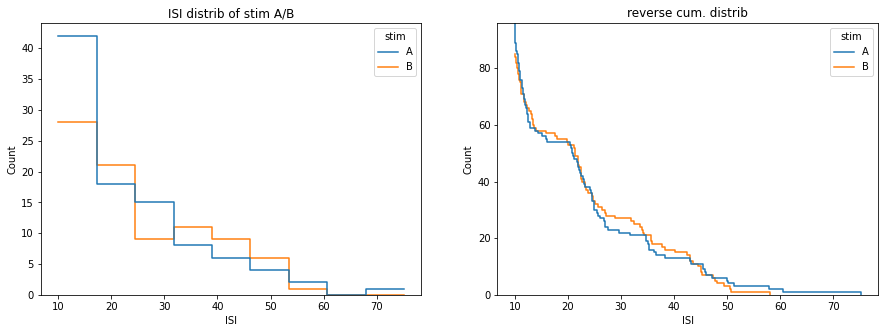

In [17]:
ISI_A = np.diff(At_vec)
ISI_B = np.diff(Bt_vec)

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.histplot(
    pd.DataFrame(dict(
        ISI = np.concatenate((ISI_A, ISI_B)),
        stim = ['A']*len(ISI_A) + ['B']*len(ISI_B)
    )),
    x='ISI',
    hue='stim',
    element='step',
    fill=False,
)
plt.title('ISI distrib of stim A/B')

plt.subplot(122)

sns.ecdfplot(
    pd.DataFrame(dict(
        ISI = np.concatenate((ISI_A, ISI_B)),
        stim = ['A']*len(ISI_A) + ['B']*len(ISI_B)
    )),
    x='ISI',
    hue='stim',
    complementary=True,
    stat='count'
)
plt.title('reverse cum. distrib')


#### 2. Number of stim A and stim B in time span of a "recorded" trial

In [18]:
len(At_vec), len(Bt_vec)

(97, 86)

In [19]:
df = (
    pd.DataFrame(dict(t = time_vec, trial = trial_vec))
    .query('trial > 0')
    .groupby('trial')
    ['t'].agg(
        lambda x: dict(start_time = min(x), stop_time = max(x))
    )
    .apply(pd.Series)
)

df = df.join(
    df.apply(
        lambda x: pd.Series(dict(
            stim_A_time = At_vec[(At_vec >= x['start_time']) & (At_vec <= x['stop_time'])],
            stim_B_time = Bt_vec[(Bt_vec >= x['start_time']) & (Bt_vec <= x['stop_time'])],
        )),
        axis=1
    )
)

df['num_stim_A'] = df['stim_A_time'].apply(len)
df['num_stim_B'] = df['stim_B_time'].apply(len)

df['stim_A_reltime'] = (df['stim_A_time'] - df['start_time'])
df['stim_B_reltime'] = (df['stim_B_time'] - df['start_time'])


In [20]:
# "valid" basically here means that the first stim (A or B)
# is within a certain time range of a trial that has a decent
# pre-stimulus and post-stimulus window so that downstream
# analysis can be done
valid_reltime_range = [5, 20]

def get_valid_reltime(v, valid_range):
    v = [
        x for x in v 
        if x >= valid_range[0] and \
        x <= valid_range[1]
    ]
    if len(v) == 0:
        return None
    return v[0]
    
df['valid_stim_A_reltime'] = df['stim_A_reltime'].apply(lambda x: get_valid_reltime(x, valid_reltime_range))
df['valid_stim_B_reltime'] = df['stim_B_reltime'].apply(lambda x: get_valid_reltime(x, valid_reltime_range))

In [21]:
df

start_time  stop_time                             stim_A_time  \
trial                                                                  
1          10.000     34.999                 [10.366, 21.79, 33.146]   
2          50.001     75.000                                [68.482]   
3          90.002    115.001                                [91.256]   
4         130.003    155.002                                      []   
5         170.004    195.003                                      []   
6         210.005    235.004                                      []   
7         250.006    275.005  [253.011, 263.927, 274.51800000000003]   
8         290.007    315.006                    [309.69100000000003]   
9         330.008    355.007                                [347.95]   
10        370.009    395.008           [377.605, 392.65500000000003]   
11        410.010    435.009                               [428.934]   
12        450.011    475.010                               [463.367]   
13        490.012    515.011                    [507.54900000000004]   
14        530.013    555.012                      [540.115, 550.963]   
15        570.014    595.013                      [572.617, 582.763]   
16        610.015    635.014                               [627.328]   
17        650.016    675.015                               [663.905]   
18        690.017    715.016                                      []   
19        730.018    755.017                     [733.9970000000001]   
20        770.019    795.018                               [779.931]   
21        810.020    835.019                               [825.076]   
22        850.021    875.020            [859.9350000000001, 869.972]   
23        890.022    915.021                               [906.369]   
24        930.023    955.022                      [931.344, 954.479]   
25        970.024    995.023                                      []   
26       1010.025   1035.024                              [1025.111]   
27       1050.026   1075.025                              [1060.141]   
28       1090.027   1115.026                              [1105.585]   
29       1130.028   1155.027                                      []   
30       1170.029   1195.028                              [1189.683]   
31       1210.030   1235.029                               [1210.19]   
32       1250.031   1275.030                              [1260.397]   
33       1290.032   1315.031                              [1305.684]   
34       1330.033   1355.032                              [1332.724]   
35       1370.034   1395.033                               [1385.16]   
36       1410.035   1435.034          [1417.413, 1429.8220000000001]   
37       1450.036   1475.035                                      []   
38       1490.037   1515.036                    [1496.455, 1506.515]   
39       1530.038   1555.037                                      []   
40       1570.039   1595.038                              [1585.259]   
41       1610.040   1635.039                    [1610.277, 1620.878]   
42       1650.041   1675.040                              [1660.111]   
43       1690.042   1715.041                                      []   
44       1730.043   1755.042                    [1735.272, 1745.404]   
45       1770.044   1795.043                    [1792.5720000000001]   
46       1810.045   1835.044                               [1824.83]   
47       1850.046   1875.045                                      []   
48       1890.047   1915.046                                      []   
49       1930.048   1955.047                              [1930.521]   
50       1970.049   1995.048                              [1984.059]   
51       2010.050   2035.049                              [2030.722]   
52       2050.051   2075.050                              [2063.531]   
53       2090.052   2115.051          [2098.7290000000003, 2110.289]   
54       2130.053   2155.052                   

In [22]:
df.query('num_stim_A > 0 and num_stim_B == 0 and not valid_stim_A_reltime.isna()').reset_index()
# df.query('num_stim_A > 0 and not valid_stim_A_reltime.isna()').reset_index()

trial  start_time  stop_time                             stim_A_time  \
0       1      10.000     34.999                 [10.366, 21.79, 33.146]   
1       7     250.006    275.005  [253.011, 263.927, 274.51800000000003]   
2      10     370.009    395.008           [377.605, 392.65500000000003]   
3      14     530.013    555.012                      [540.115, 550.963]   
4      15     570.014    595.013                      [572.617, 582.763]   
5      22     850.021    875.020            [859.9350000000001, 869.972]   
6      26    1010.025   1035.024                              [1025.111]   
7      36    1410.035   1435.034          [1417.413, 1429.8220000000001]   
8      38    1490.037   1515.036                    [1496.455, 1506.515]   
9      40    1570.039   1595.038                              [1585.259]   
10     41    1610.040   1635.039                    [1610.277, 1620.878]   
11     42    1650.041   1675.040                              [1660.111]   
12     44    1730.043   1755.042                    [1735.272, 1745.404]   
13     50    1970.049   1995.048                              [1984.059]   
14     53    2090.052   2115.051          [2098.7290000000003, 2110.289]   
15     56    2210.055   2235.054                     [2216.942, 2227.61]   

   stim_B_time  num_stim_A  num_stim_B  \
0           []           3           0   
1           []           3           0   
2           []           2           0   
3           []           2           0   
4           []           2           0   
5           []           2           0   
6           []           1           0   
7           []           2           0   
8           []           2           0   
9           []           1           0   
10          []           2           0   
11          []           1           0   
12          []           2           0   
13          []           1           0   
14          []           2           0   
15          []           2           0   

                                       stim_A_reltime stim_B_reltime  \
0                [0.36599999999999966, 11.79, 23.146]             []   
1   [3.0049999999999955, 13.92100000000002, 24.512...             []   
2             [7.596000000000004, 22.646000000000015]             []   
3            [10.101999999999975, 20.949999999999932]             []   
4             [2.602999999999952, 12.749000000000024]             []   
5             [9.913999999999987, 19.950999999999908]             []   
6                                [15.086000000000126]             []   
7             [7.377999999999929, 19.787000000000035]             []   
8             [6.417999999999893, 16.478000000000065]             []   
9                                [15.220000000000027]             []   
10          [0.23700000000008004, 10.837999999999965]             []   
11                               [10.070000000000164]             []   
12           [5.2289999999998145, 15.360999999999876]             []   
13                               [14.009999999999991]             []   
14             [8.677000000000135, 20.23700000000008]             []   
15             [6.887000000000171, 17.55500000000029]             []   

    valid_stim_A_reltime  valid_stim_B_reltime  
0                 11.790                   NaN  
1                 13.921                   NaN  
2                  7.596                   NaN  
3                 10.102                   NaN  
4                 12.749                   NaN  
5                  9.914                   NaN  
6                 15.086                   NaN  
7                  7.378                   NaN  
8                  6.418                   NaN  
9                 15.220                   NaN  
10                10.838                   NaN  
11                10.070                   NaN  
12                 5.229                   NaN  
13                14.010                   NaN  
14                 8.677            

In [23]:
df.query('num_stim_B > 0 and num_stim_A == 0 and not valid_stim_B_reltime.isna()').reset_index()
# df.query('num_stim_B > 0 and not valid_stim_B_reltime.isna()').reset_index()

trial  start_time  stop_time stim_A_time  \
0       4     130.003    155.002          []   
1       5     170.004    195.003          []   
2       6     210.005    235.004          []   
3      18     690.017    715.016          []   
4      25     970.024    995.023          []   
5      29    1130.028   1155.027          []   
6      37    1450.036   1475.035          []   
7      39    1530.038   1555.037          []   
8      43    1690.042   1715.041          []   
9      47    1850.046   1875.045          []   
10     48    1890.047   1915.046          []   

                                 stim_B_time  num_stim_A  num_stim_B  \
0                         [139.156, 151.477]           0           2   
1                                  [184.005]           0           1   
2                           [218.115, 228.9]           0           2   
3                         [700.117, 711.926]           0           2   
4                                  [976.485]           0           1   
5                       [1133.481, 1144.577]           0           2   
6              [1452.472, 1463.078, 1473.38]           0           3   
7                                 [1538.964]           0           1   
8   [1695.5710000000001, 1711.5240000000001]           0           2   
9                       [1858.952, 1872.375]           0           2   
10            [1894.301, 1906.5130000000001]           0           2   

   stim_A_reltime                                     stim_B_reltime  \
0              []             [9.152999999999992, 21.47399999999999]   
1              []                               [14.001000000000005]   
2              []             [8.110000000000014, 18.89500000000001]   
3              []           [10.099999999999909, 21.908999999999992]   
4              []                                [6.461000000000013]   
5              []           [3.4529999999999745, 14.548999999999978]   
6              []  [2.435999999999922, 13.041999999999916, 23.344...   
7              []                                 [8.92599999999993]   
8              []             [5.528999999999996, 21.48199999999997]   
9              []             [8.905999999999949, 22.32899999999995]   
10             []            [4.253999999999905, 16.466000000000122]   

    valid_stim_A_reltime  valid_stim_B_reltime  
0                    NaN                 9.153  
1                    NaN                14.001  
2                    NaN                 8.110  
3                    NaN                10.100  
4                    NaN                 6.461  
5                    NaN                14.549  
6                    NaN                13.042  
7                    NaN                 8.926  
8                    NaN                 5.529  
9                    NaN                 8.906  
10                   NaN                16.466

#### 3. Stimulus-behavior association

Text(0.5, 1.0, 'stim triggered average of sniff rate')

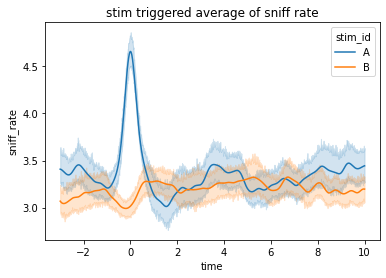

In [24]:
# event/stim triggered average of behavior
# basically to double check if:
# - stim A is really strongly associated with high sniff
# - and stim B is not, and sort of random

t_range = [-3,10] # time range before and after
time_skip = 10 # don't need to sample everything

eta_df = pd.DataFrame(dict(
    stim_time = np.concatenate([At_vec, Bt_vec]),
    stim_id = ['A'] * len(At_vec) + ['B'] * len(Bt_vec)
))

eta_df['sniff_rate'] = eta_df['stim_time'].apply(
    lambda x: sniff_rate[
        (t > x + t_range[0]) &
        (t < x + t_range[1])
    ]
)
# good enough estimation; a bit not so rigorous
min_sample = eta_df['sniff_rate'].apply(len).min()
eta_df['sniff_rate'] = eta_df['sniff_rate'].apply(
    lambda x: x[:min_sample][::time_skip]
)
eta_df['time'] = eta_df['sniff_rate'].apply(
    lambda x: np.linspace(*t_range, len(x))
)
eta_df = (
    eta_df
    .explode(['sniff_rate', 'time'])
    .reset_index(drop=True)
)

# plot
sns.lineplot(
    eta_df,
    x = 'time',
    y = 'sniff_rate',
    hue = 'stim_id',
    n_boot=100,
)
plt.title('stim triggered average of sniff rate')